### 실습 목차
* 1. ELECTRA 모델 구조
  * 1-1. ELECTRA 모델 불러오기
* 2. ELECTRA Pre-training
  * 2-1. ELECTRA 토크나이저 불러오기
  * 2-2. Generator 구조
  * 2-3. Discriminator 구조
* 3. ELECTRA Fine-tuning
  * 3-1. Single Sentence Classification Task

In [ ]:
# 라이브러리 import
import wget
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl

from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.metrics import matthews_corrcoef
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from transformers import ElectraModel, AutoTokenizer, ElectraForMaskedLM, ElectraForPreTraining, ElectraForSequenceClassification, BertForSequenceClassification, AutoConfig, AutoModelForSequenceClassification

## 1. ELECTRA 모델 구조
```
💡 ELECTRA 모델이 가지는 embedding layer와 encoder layer 구조를 살펴봅니다.
```

### 1-1. ELECTRA 모델 불러오기

In [ ]:
# ELECTRA 모델 불러오기
model = ElectraModel.from_pretrained("google/electra-small-discriminator")

In [ ]:
# ELECTRA의 총 파라미터 수
model.num_parameters()

13483008

In [ ]:
# ELECTRA 모델 전체 구조
model

ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0-11): 12 x ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((

## 2. ELECTRA Pretraining

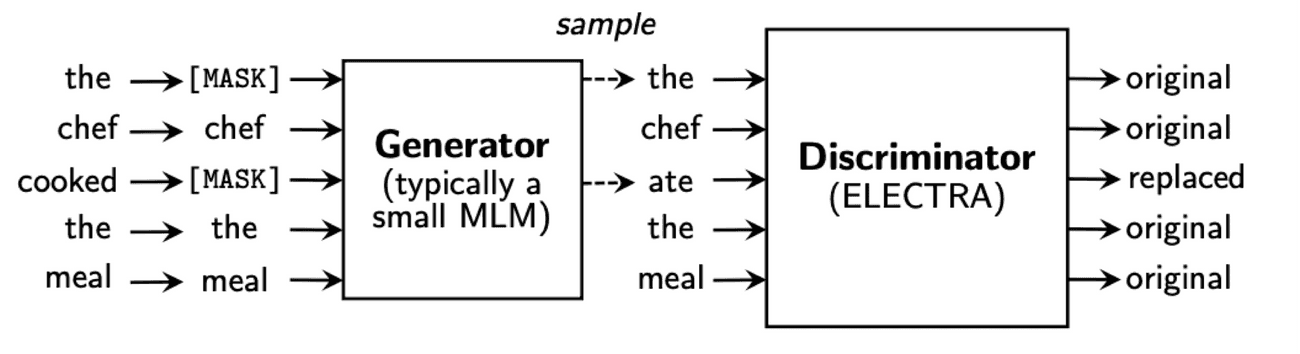

ELECTRA는 RTD(Replaced Token Detection) 태스크를 통해 사전 학습이 진행됩니다. RTD 태스크를 학습하기 위하서 Generator와 Discriminator, 두 개의 네트워크가 필요합니다. 두 네트워크는 공통적으로 Transformer 인코더 구조이며, 토큰 시퀀스를 입력으로 받아 벡터로 임베딩합니다.
- Generator 모델에서 문장 토큰 중 약 15%를 바꿔 가짜 문장을 만듭니다.
- Discriminator는 모든 문장에 대해 진짜 토큰인지, 가짜 토큰인지 구별하는 과정에서 학습을 수행합니다.


### 2-1. ELECTRA 토크나이저 불러오기
입력 문장을 토큰화하기 위해 토크나이저를 불러옵니다. ELECTRA는 BERT와 같이 WordPiece 토크나이저를 사용합니다.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")

In [ ]:
tokens = tokenizer("I love NLP and I love AI!")
print("input_tokens : ", tokenizer.convert_ids_to_tokens(tokens['input_ids']))

input_tokens :  ['[CLS]', 'i', 'love', 'nl', '##p', 'and', 'i', 'love', 'ai', '!', '[SEP]']


### 2-2. Generator 구조
Generator에서는 기존 BERT의 MLM(Mased Language Modeling)과 같은 학습 매커니즘을 수행합니다. `ElectraForMaskedLM` 모듈을 통해 Generator를 불러옵니다.

In [ ]:
generator = ElectraForMaskedLM.from_pretrained('google/electra-base-generator')

In [ ]:
generator

ElectraForMaskedLM(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=768, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_featur

`generator_predictions` layerd에서 last_hidden_states를 입력으로 받아 최종적으로 `generator_lm_head` layer에서 [MASK] 토큰에 적합한 토큰을 예측합니다.

In [ ]:
inputs = tokenizer("The capital of Korea is [MASK].", return_tensors="pt")
# inputs = tokenizer("I love NLP and I [MASK] AI!.", return_tensors="pt")

print("input_tokens : ", tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))

# Generator 모델에 토큰화된 시퀀스를 입력하여
# [MASK] 토큰에 적합한 토큰을 예측합니다.
with torch.no_grad():
    logits = generator(**inputs).logits
print("logits :", logits)

# [MASK] 토큰의 인덱스를 가져옵니다.
mask_token_index = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
print("mask_token_index: ", mask_token_index)

predicted_token_id = logits[0, mask_token_index].argmax(axis=-1)
print("predicted_token_id: ", tokenizer.decode(predicted_token_id))

input_tokens :  ['[CLS]', 'the', 'capital', 'of', 'korea', 'is', '[MASK]', '.', '[SEP]']
logits : tensor([[[ 18.0910,  -6.8586,  -7.0145,  ...,  -6.8326,  -6.8674,  -6.8558],
         [-11.5750,  -9.3866,  -9.3830,  ...,  -9.3469,  -9.3428,  -9.3816],
         [-31.1483, -11.2327, -11.3240,  ..., -11.2212, -11.2209, -11.2338],
         ...,
         [  0.2970,  -6.1463,  -6.0732,  ...,  -6.1457,  -6.1446,  -6.1540],
         [ 17.3836,  -7.0320,  -7.1834,  ...,  -7.0049,  -7.0401,  -7.0281],
         [ 18.0900,  -6.8587,  -7.0146,  ...,  -6.8327,  -6.8675,  -6.8559]]])
mask_token_index:  tensor([6])
predicted_token_id:  seoul


In [ ]:
generator_labels = tokenizer("The capital of Korea is Seoul.", return_tensors="pt")["input_ids"]
print(generator_labels)

# [MASK] 토큰이 아닌 토큰들을 마스킹
generator_labels = torch.where(inputs.input_ids == tokenizer.mask_token_id, generator_labels, -100)
print(generator_labels)

tensor([[  101,  1996,  3007,  1997,  4420,  2003, 10884,  1012,   102]])
tensor([[ -100,  -100,  -100,  -100,  -100,  -100, 10884,  -100,  -100]])


In [ ]:
generator_outputs = generator(**inputs, labels=generator_labels)
gen_loss = generator_outputs.loss.item()
print("Prediction에 대한 loss: ", gen_loss)

Prediction에 대한 loss:  1.9064574241638184


Generator는 [MASK] 토큰에 대해서 단어를 예측하며 학습이 진행됩니다.

### 2-3. Discriminator 구조
Discriminator에서는 가짜 문장을 통해 개별 토큰에 대해 진위여부를 판단하며 사전 학습이 진행됩니다. Generator에서 생성한 문장을 입력으로 받아 진짜 token이라고 판단되면 0, 가짜 토큰이라고 판단되면 1을 부여하여 정답과 비교합니다. `ElectraForPreTraining` 모듈을 통해 Discriminator를 불러옵니다.

In [ ]:
discriminator = ElectraForPreTraining.from_pretrained("google/electra-base-discriminator")

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForPreTraining: ['electra.embeddings_project.weight', 'electra.embeddings_project.bias']
- This IS expected if you are initializing ElectraForPreTraining from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForPreTraining from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
discriminator

ElectraForPreTraining(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

In [ ]:
sentence = "The capital of Korea is Seoul"
fake_sentence = "The capital of Korea is craters"

orignial_tokens = tokenizer(sentence, return_tensors="pt")
fake_tokens = tokenizer(fake_sentence, return_tensors="pt")
print("fake_tokens : ", tokenizer.convert_ids_to_tokens(fake_tokens['input_ids'][0]))
# with torch.no_grad():
discriminator_outputs = discriminator(**fake_tokens)

predictions = torch.round((torch.sign(discriminator_outputs[0]) + 1) / 2)
print(discriminator_outputs[0])
print(predictions)

fake_tokens :  ['[CLS]', 'the', 'capital', 'of', 'korea', 'is', 'craters', '[SEP]']
tensor([[-4.4304, -5.5424, -3.1928, -6.0305, -2.1343, -3.9688, -0.1745, -4.4304]],
       grad_fn=<SqueezeBackward1>)


6번째의 토큰이 가장 높은 값으로 가짜 토큰으로 판별되는 것을 확인할 수 있습니다.

In [ ]:
discriminator_labels = orignial_tokens['input_ids'] != fake_tokens['input_ids'].float().detach()
print(discriminator_labels)

discriminator_outputs = discriminator(**fake_tokens, labels=discriminator_labels)
disc_loss = discriminator_outputs.loss.item()
print("Prediction에 대한 loss: ", disc_loss)

tensor([[False, False, False, False, False, False,  True, False]])
Prediction에 대한 loss:  0.1231207400560379


In [ ]:
gen_weight, disc_weight = 1.0, 50.0

combined_loss = gen_weight * gen_loss + disc_weight * disc_loss
print(combined_loss)

8.062494426965714


ELECTRA는 Generator의 loss와 Discriminator의 loss를 결합하여 학습을 수행합니다. Generator는 vocab_size(=30522)만큼의 loss 계산을 수행하지만 Discriminator는 입력 토큰 길이만큼의 loss 계산을 수행하기 때문에 각각 다른 weight를 주어 loss의 비율을 조절해줍니다.

## 2. ELECTRA Finetuning
BERT에서 수행했던 downstream task 중 CoLA 데이터를 활용하여 ELECTRA의 성능을 확인 후 BERT와 비교해봅니다.

### 3-1. Single Sentence Classification Task
- 모델에 입력되는 단일 문장의 종류를 분류하는 문제입니다.
- Task에 대해 모델을 평가하기 위한 데이터셋으로 CoLA (The Corpus of Linguisic Acceptability)를 사용합니다. CoLA는 문장마다 문법적으로 올바르거나 잘못된 것으로 레이블이 지정된 데이터입니다.
- 평가지표는 Matthews correlation을 사용합니다.

#### 학습 데이터 준비

In [ ]:
# CoLA 데이터셋 다운로드
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
wget.download(url, './cola_public_1.1.zip')

'./cola_public_1.1.zip'

In [ ]:
!unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [ ]:
df_train = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_train = df_train.loc[:, ['sentence', 'label']]
df_train

,sentence,label
0,"Our friends won't buy this analysis, let alone...",1
1,One more pseudo generalization and I'm giving up.,1
2,One more pseudo generalization or I'm giving up.,1
3,"The more we study verbs, the crazier they get.",1
4,Day by day the facts are getting murkier.,1
...,...,...
8546,Poseidon appears to own a dragon,0
8547,Digitize is my happiest memory,0
8548,It is easy to slay the Gorgon.,1
8549,I had the strangest feeling that I knew you.,1


#### 데이터 토큰화

In [ ]:
def load_tokenizer_and_model_for_train():
    """학습(train)을 위한 사전학습(pretrained) 토크나이저와 모델을 huggingface에서 load"""
    MODEL_NAME = args_train.model_name
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model_config = AutoConfig.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=model_config)
    print("--- Modeling Done ---")
    return tokenizer , model

In [ ]:
def tokenized_dataset(dataset, tokenizer):
    print()
    print("tokenizer 에 들어가는 데이터 형태")
    print(list(dataset["sentence"])[-1])
    tokenized_senetences = tokenizer(list(dataset["sentence"]),
                                     add_special_tokens = True, # [CLS], [SEP] 토큰 추가
                                     max_length = 64,           # 패딩/잘라내기를 위한 최대 문장 길이
                                     pad_to_max_length = True,
                                     return_attention_mask = True,   # attention masks 출력
                                     return_tensors = 'pt',
                                     )
    print("tokenizing 된 데이터 형태")
    print(tokenizer.convert_ids_to_tokens(tokenized_senetences['input_ids'][-1]))
    print(tokenized_senetences['input_ids'][-1])
    print()
    return tokenized_senetences

In [ ]:
class ClsDataset(torch.utils.data.Dataset):
    """dataframe을 torch dataset class로 변환"""
    def __init__(self, news_dataset, labels):
        self.dataset = news_dataset
        self.labels = labels

    def __getitem__(self,idx):
        item = {
            key: val[idx].clone().detach() for key, val in self.dataset.items()
        }
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

#### 학습 및 검증 데이터 분할
학습에 90%, 검증에 10%를 사용하도록 학습 세트를 나눕니다.

In [ ]:
def prepare_dataset(dataset, tokenizer):
    """학습(train), 평가(test)를 위한 데이터셋을 준비"""
    # split train / test = 9 : 1
    train_dataset, valid_dataset = train_test_split(dataset,
                                                  test_size=0.1,
                                                  random_state=42
                                                  )
    # input_ids, token_type_ids, attention_mask 생성
    tokenized_train = tokenized_dataset(train_dataset, tokenizer)
    tokenized_valid = tokenized_dataset(valid_dataset, tokenizer)

    # split label
    train_label = train_dataset['label'].values
    valid_label = valid_dataset['label'].values
    print("--- tokenizing Done ---")

    # make dataset for pytorch.
    cls_train_dataset = ClsDataset(tokenized_train, train_label)
    cls_valid_dataset = ClsDataset(tokenized_valid, valid_label)
    print("--- dataset class Done ---")

    return cls_train_dataset, cls_valid_dataset

#### 모델 학습

In [ ]:
def load_trainer_for_train(model, train_dataset, test_dataset, tokenizer):
    """학습(train)을 위한 huggingface trainer 설정"""
    training_args = TrainingArguments(
        output_dir='./',
        per_device_train_batch_size=16,
        num_train_epochs=1
    )
    print("--- Set training arguments Done ---")

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset
    )
    print("--- Set Trainer Done ---")

    return trainer

In [ ]:
def train(dataset):
    """모델을 학습(train)하고 best model을 저장"""
    # fix a seed
    pl.seed_everything(seed=42, workers=False)

    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device:", device)

    # set model and tokenizer
    tokenizer, model = load_tokenizer_and_model_for_train()
    model.to(device)
    print("Model 확인: ", model)

    # set data
    cls_train_dataset, cls_valid_dataset = prepare_dataset(dataset, tokenizer)

    # set trainer
    trainer = load_trainer_for_train(model, cls_train_dataset, cls_valid_dataset, tokenizer)

    # train model
    print("--- Start train ---")
    trainer.train()
    print("--- Finish train ---")
    model.save_pretrained("./best_model")

In [ ]:
class args_train():
    """학습(train)에 사용되는 arguments 관리하는 class"""
    model_name = "google/electra-base-discriminator"

train(df_train[:50])

INFO:lightning_fabric.utilities.seed:Seed set to 42


device: cuda:0


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Modeling Done ---


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Model 확인:  ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Step,Training Loss


--- Finish train ---


#### 모델 테스트

In [ ]:
df_test = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_test.head()

,sentence_source,label,label_notes,sentence
0,clc95,1,NaN,Somebody just left - guess who.
1,clc95,1,NaN,"They claimed they had settled on something, bu..."
2,clc95,1,NaN,"If Sam was going, Sally would know where."
3,clc95,1,NaN,"They're going to serve the guests something, b..."
4,clc95,1,NaN,She's reading. I can't imagine what.


In [ ]:
def load_model_for_inference():
    """추론(infer)에 필요한 모델과 토크나이저 load """
    MODEL_NAME = args_test.model_name
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model_config = AutoConfig.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
    print("--- Modeling Done ---")
    return tokenizer, model

In [ ]:
def inference(model, tokenized_sent, device):
    """학습된(trained) 모델을 통해 결과를 추론하는 function"""
    dataloader = DataLoader(tokenized_sent, batch_size=args_test.batch_size, shuffle=False)
    model.eval()
    output_pred = []
    for i, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            outputs = model(
                input_ids=data["input_ids"].to(device),
                attention_mask=data["attention_mask"].to(device)
            )
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        result = np.argmax(logits, axis=-1)

        output_pred.append(result)
    return (np.concatenate(output_pred).tolist(),)

In [ ]:
def infer_and_eval(test_dataset):
    """학습된 모델로 추론(infer)한 후에 예측한 결과(pred)를 평가(eval)"""
    # set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # set model & tokenizer
    tokenizer, model = load_model_for_inference()
    model.to(device)

    # set data
    tokenized_test = tokenized_dataset(test_dataset, tokenizer)
    test_label = test_dataset['label'].values
    cls_test_dataset = ClsDataset(tokenized_test, test_label)

    # return model, tokenized_test, test_label, cls_test_dataset

    # predict answer
    pred_answer = inference(model, cls_test_dataset, device)  # model에서 class 추론
    print("--- Prediction done ---")

    print("test_label: ", list(test_label[:30]))
    print("pred_answer: ", pred_answer[0][:30])

    mcc = matthews_corrcoef(test_label, pred_answer[0])
    print("\n ----- Total MCC: %.3f -----" % mcc)


CoLA 벤치마크의 정확도는 "MCC(Mathews Correlation Coefficient)"를 사용하여 측정합니다.

In [ ]:
class args_test():
    """학습(train)에 사용되는 arguments 관리하는 class"""
    model_name = "D3xter1922/electra-base-discriminator-finetuned-cola"
    batch_size = 64

infer_and_eval(df_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


--- Modeling Done ---

tokenizer 에 들어가는 데이터 형태
John talked to Bill about himself.


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tokenizing 된 데이터 형태
['[CLS]', 'john', 'talked', 'to', 'bill', 'about', 'himself', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
tensor([ 101, 2198, 5720, 2000, 3021, 2055, 2370, 1012,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         

100%|██████████| 9/9 [00:01<00:00,  5.75it/s]

--- Prediction done ---
test_label:  [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]
pred_answer:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

 ----- Total MCC: 0.651 -----
